# BO with `ax_platform=0.4.3`

In [11]:
import asyncio
import numpy as np
import torch
from ax.service.ax_client import AxClient
from ax.modelbridge.generation_strategy import GenerationStrategy, GenerationStep
from ax.modelbridge.registry import Models
from ax.models.torch.botorch_modular.surrogate import Surrogate
from botorch.acquisition import qNegIntegratedPosteriorVariance
from botorch.models.gp_regression import SingleTaskGP
from ax.service.utils.instantiation import ObjectiveProperties
import random
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import numpy as np


class ZReader:
    """Fake response object simulating a noisy Gaussian-like surface as the objective."""

    def __init__(self, centers, sigma=0.1, n_samples=1):
        """
        Initialize the Gaussian response surface.

        Args:
            centers (list): The "peak" of the Gaussian for each parameter.
            sigma (float): Spread of the Gaussian.
            n_samples (int): Number of samples to simulate measurement noise.
        """
        self.centers = np.array(centers)
        self.sigma = sigma
        self.n_samples = n_samples

    def read(self, params):
        """
        Compute the objective value (mean and SEM if multiple samples).

        Args:
            params (list): Parameter values at which to evaluate.
        Returns:
            tuple: (mean, sem) representing the evaluated objective and its SEM.
        """
        params = np.array(params)
        # Gaussian-like function
        z = np.exp(-np.sum((params - self.centers) ** 2) / (2 * self.sigma**2))
        if self.n_samples > 1:
            # Add noise for multiple samples and compute mean and SEM
            noisy_z = [
                z + np.random.normal(0, self.sigma) for _ in range(self.n_samples)
            ]
            mean_z = np.mean(noisy_z)
            sem_z = np.std(noisy_z) / np.sqrt(self.n_samples)
            return mean_z, sem_z
        return z, 0.0


async def get_next_batch_async(ax_client, batch_size):
    """Asynchronously request the next batch of trials from AxClient."""
    loop = asyncio.get_event_loop()
    return await asyncio.gather(
        *[
            loop.run_in_executor(None, ax_client.get_next_trial)
            for _ in range(batch_size)
        ]
    )


async def complete_trial_async(ax_client, trial_index, result):
    """Asynchronously mark a given trial as completed with results."""
    loop = asyncio.get_event_loop()
    return await loop.run_in_executor(
        None, ax_client.complete_trial, trial_index, result
    )


async def bayesian_optimizer_iterator(
    z_reader,
    param_names,
    param_bounds,
    num_initial_samples=10,
    num_bo_samples=20,
    batch_size=1,
    explore_ratio=0.1,
    threshold=None,
    epsilon=0.0,
    patience=10,
):
    """
    An asynchronous Bayesian optimization iterator using Ax and BoTorch with early stopping criteria.

    This tries up to `num_bo_samples` Bayesian optimization steps beyond the initial samples.
    If early stopping conditions (threshold or lack of improvement) are met before reaching
    `num_bo_samples`, the iteration stops early.

    Args:
        z_reader: Object with a .read() method that returns (mean, sem) for given params.
        param_names (list): Names of each parameter.
        param_bounds (list): Bounds for each parameter as (min, max).
        num_initial_samples (int): Number of initial random samples via Sobol sequence.
        num_bo_samples (int): Maximum number of Bayesian optimization steps (beyond initial samples).
        batch_size (int): Number of trials per batch.
        explore_ratio (float): Probability of using qNIPV-based exploration.
        threshold (float or None): If best observed value > threshold, stop early.
        epsilon (float): Minimum absolute improvement in exploitation steps to reset patience.
        patience (int): Number of exploitation steps allowed without improvement above epsilon before stopping.

    Yields:
        dict: Parameter dictionary suggested by the optimizer for evaluation.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define strategy: start with Sobol, then GPEI
    generation_strategy = GenerationStrategy(
        steps=[
            GenerationStep(model=Models.SOBOL, num_trials=num_initial_samples),
            GenerationStep(
                model=Models.GPEI, num_trials=-1, max_parallelism=batch_size
            ),
        ]
    )

    # Create a new experiment in Ax
    ax_client = AxClient(generation_strategy=generation_strategy, torch_device=device)
    ax_client.create_experiment(
        name="modular_iterator_optimization",
        parameters=[
            {"name": name, "type": "range", "bounds": bounds}
            for name, bounds in zip(param_names, param_bounds)
        ],
        objectives={"z": ObjectiveProperties(minimize=False)},
        parameter_constraints=[],
        tracking_metric_names=[],
    )

    best_value = float("-inf")
    no_improvement_count = 0

    # Generate initial Sobol samples
    trials = await get_next_batch_async(ax_client, num_initial_samples)
    for params, trial_index in trials:
        yield params
        z_mean, z_sem = z_reader.read([params[name] for name in param_names])
        await complete_trial_async(ax_client, trial_index, {"z": (z_mean, z_sem)})
        if z_mean > best_value:
            best_value = z_mean
            no_improvement_count = 0

    last_best_value = best_value

    # Main Bayesian optimization loop, up to `num_bo_samples` steps
    # Each step may involve multiple trials if batch_size > 1
    steps_taken = 0
    while steps_taken < num_bo_samples:
        current_batch_size = min(batch_size, num_bo_samples - steps_taken)

        # Decide if we explore (qNIPV) or exploit (GPEI)
        explore = np.random.rand() < explore_ratio
        if explore:
            print("Using qNIPV (Exploration)")
            ax_client.generation_strategy._steps[-1].model = Models.BOTORCH_MODULAR
            ax_client.generation_strategy._steps[-1].model_kwargs = {
                "surrogate": Surrogate(SingleTaskGP),
                "botorch_acqf_class": qNegIntegratedPosteriorVariance,
                "acquisition_options": {"mc_points": 50},
            }
        else:
            print("Using GPEI (Exploitation)")
            ax_client.generation_strategy._steps[-1].model = Models.GPEI
            ax_client.generation_strategy._steps[-1].model_kwargs = {}

        trials = await get_next_batch_async(ax_client, current_batch_size)
        for params, trial_index in trials:
            yield params
            z_mean, z_sem = z_reader.read([params[name] for name in param_names])
            await complete_trial_async(ax_client, trial_index, {"z": (z_mean, z_sem)})

            # Check improvement
            if z_mean > best_value:
                improvement = z_mean - best_value
                best_value = z_mean
                # Reset patience only if we are in exploitation mode
                if not explore:
                    no_improvement_count = 0
            else:
                # If exploitation step and no improvement >= epsilon
                if not explore:
                    if best_value - last_best_value < epsilon:
                        no_improvement_count += 1

            last_best_value = best_value

            # Early stopping checks
            if threshold is not None and best_value > threshold:
                print("Stopping early: threshold exceeded.")
                return

            if not explore and no_improvement_count > patience:
                print(
                    "Stopping early: no sufficient improvement in exploitation steps."
                )
                return

        steps_taken += 1


def bayesian_optimizer_iterator_sync(
    z_reader,
    param_names,
    param_bounds,
    num_initial_samples=10,
    num_bo_samples=20,
    batch_size=1,
    explore_ratio=0.1,
    threshold=None,
    epsilon=0.0,
    patience=10,
):
    """
    A synchronous version of the Bayesian optimization iterator with early stopping.

    This tries up to `num_bo_samples` Bayesian optimization steps beyond the initial samples.
    If early stopping conditions are met before reaching `num_bo_samples`, the iteration stops early.

    Args:
        z_reader: Object with a .read() method returning (mean, sem).
        param_names (list): Parameter names.
        param_bounds (list): Parameter bounds as (min, max).
        num_initial_samples (int): Number of initial Sobol samples.
        num_bo_samples (int): Maximum number of BO steps.
        batch_size (int): Trials per batch.
        explore_ratio (float): Probability of switching to qNIPV exploration.
        threshold (float or None): If best observed value > threshold, stop early.
        epsilon (float): Minimum absolute improvement to reset patience in exploitation steps.
        patience (int): Number of exploitation steps allowed without improvement above epsilon before stopping.

    Yields:
        dict: Parameter sets suggested by the optimizer.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Generation strategy
    generation_strategy = GenerationStrategy(
        steps=[
            GenerationStep(model=Models.SOBOL, num_trials=num_initial_samples),
            GenerationStep(
                model=Models.GPEI, num_trials=-1, max_parallelism=batch_size
            ),
        ]
    )

    # Set up the Ax experiment
    ax_client = AxClient(generation_strategy=generation_strategy, torch_device=device)
    ax_client.create_experiment(
        name="modular_iterator_optimization_sync",
        parameters=[
            {"name": name, "type": "range", "bounds": bounds}
            for name, bounds in zip(param_names, param_bounds)
        ],
        objectives={"z": ObjectiveProperties(minimize=False)},
        parameter_constraints=[],
        tracking_metric_names=[],
    )

    best_value = float("-inf")
    no_improvement_count = 0

    # Initial Sobol samples
    for _ in range(num_initial_samples):
        params, trial_index = ax_client.get_next_trial()
        yield params
        z_mean, z_sem = z_reader.read([params[name] for name in param_names])
        ax_client.complete_trial(trial_index, {"z": (z_mean, z_sem)})
        if z_mean > best_value:
            best_value = z_mean
            no_improvement_count = 0

    last_best_value = best_value

    # Main BO loop: up to num_bo_samples steps
    for step in range(num_bo_samples):
        current_batch_size = min(batch_size, num_bo_samples - step)

        # Explore or exploit based on random draw
        explore = np.random.rand() < explore_ratio
        if explore:
            print("Using qNIPV (Exploration)")
            ax_client.generation_strategy._steps[-1].model = Models.BOTORCH_MODULAR
            ax_client.generation_strategy._steps[-1].model_kwargs = {
                "surrogate": Surrogate(SingleTaskGP),
                "botorch_acqf_class": qNegIntegratedPosteriorVariance,
                "acquisition_options": {"mc_points": 50},
            }
        else:
            print("Using GPEI (Exploitation)")
            ax_client.generation_strategy._steps[-1].model = Models.GPEI
            ax_client.generation_strategy._steps[-1].model_kwargs = {}

        # Generate and complete trials
        for _ in range(current_batch_size):
            params, trial_index = ax_client.get_next_trial()
            yield params
            z_mean, z_sem = z_reader.read([params[name] for name in param_names])
            ax_client.complete_trial(trial_index, {"z": (z_mean, z_sem)})

            # Check improvements
            if z_mean > best_value:
                improvement = z_mean - best_value
                best_value = z_mean
                # Reset patience only if in exploitation
                if not explore:
                    no_improvement_count = 0
            else:
                # If exploitation step and no improvement >= epsilon
                if not explore:
                    if best_value - last_best_value < epsilon:
                        no_improvement_count += 1

            last_best_value = best_value

            # Early stopping checks
            if threshold is not None and best_value > threshold:
                print("Stopping early: threshold exceeded.")
                return

            if not explore and no_improvement_count > patience:
                print(
                    "Stopping early: no sufficient improvement in exploitation steps."
                )
                return

# Running the BO


In [32]:
# Define parameter names and their respective bounds
param_names = ["a", "b"]
param_bounds = [[-1.0, 1.0], [-1.0, 1.0]]

# Initialize the response reader with a fake Gaussian-like objective
z_reader = ZReader(centers=[0.2, 0.1], sigma=0.1, n_samples=1)

# Storage for the optimization history
suggested_params = []
observed_z = []
best_result = {
    "params": None,
    "value": float("-inf"),
}


# Set your stopping criteria
THRESHOLD = 0.999  # Stop if we exceed this value
EPSILON = 0.001  # Minimum improvement needed
PATIENCE = 10  # Number of exploitation steps without improvement


mode = "async"

if mode == "async":
    async for params in bayesian_optimizer_iterator(
        z_reader,
        param_names,
        param_bounds,
        num_initial_samples=20,
        num_bo_samples=20,
        batch_size=2,
        explore_ratio=0.1,
        threshold=THRESHOLD,
        epsilon=EPSILON,
        patience=PATIENCE,
    ):
        z_mean, z_sem = z_reader.read([params[name] for name in param_names])
        suggested_params.append(params)
        observed_z.append(z_mean)
        if z_mean > best_result["value"]:
            best_result = {"params": params, "value": z_mean}

else:
    for params in bayesian_optimizer_iterator_sync(
        z_reader,
        param_names,
        param_bounds,
        num_initial_samples=20,
        num_bo_samples=20,
        batch_size=2,
        explore_ratio=0.1,
        threshold=THRESHOLD,
        epsilon=EPSILON,
        patience=PATIENCE,
    ):
        z_mean, z_sem = z_reader.read([params[name] for name in param_names])
        suggested_params.append(params)
        observed_z.append(z_mean)
        if z_mean > best_result["value"]:
            best_result = {"params": params, "value": z_mean}

results = {
    "suggested_params": suggested_params,
    "observed_z": observed_z,
    "best_result": best_result,
}

[INFO 12-14 00:16:07] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 12-14 00:16:07] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter a. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-14 00:16:07] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter b. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-14 00:16:07] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='a', parameter_type=FLOAT, range=[-1.0, 1.0]), RangeParameter(name='b', parameter_type=FLOAT, range=[-1.0, 1.0])], parameter_constraints=[]).
[INFO 12-14 00:16:07]

Using GPEI (Exploitation)


[INFO 12-14 00:16:07] ax.service.ax_client: Generated new trial 20 with parameters {'a': 0.180487, 'b': -0.467368} using model GPEI.
[INFO 12-14 00:16:08] ax.service.ax_client: Generated new trial 21 with parameters {'a': 0.180479, 'b': -0.467397} using model GPEI.
[INFO 12-14 00:16:08] ax.service.ax_client: Completed trial 21 with data: {'z': (0.0, 0.0)}.
[INFO 12-14 00:16:08] ax.service.ax_client: Completed trial 20 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-14 00:16:08] ax.service.ax_client: Generated new trial 22 with parameters {'a': 0.180299, 'b': -0.468192} using model GPEI.
[INFO 12-14 00:16:08] ax.service.ax_client: Generated new trial 23 with parameters {'a': 0.484268, 'b': -0.261655} using model GPEI.
[INFO 12-14 00:16:08] ax.service.ax_client: Completed trial 22 with data: {'z': (0.0, 0.0)}.
[INFO 12-14 00:16:08] ax.service.ax_client: Completed trial 23 with data: {'z': (2.5e-05, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-14 00:16:09] ax.service.ax_client: Generated new trial 24 with parameters {'a': 0.48505, 'b': -0.26161} using model GPEI.
[INFO 12-14 00:16:10] ax.service.ax_client: Generated new trial 25 with parameters {'a': 0.213395, 'b': -0.251541} using model GPEI.
[INFO 12-14 00:16:10] ax.service.ax_client: Completed trial 24 with data: {'z': (2.5e-05, 0.0)}.
[INFO 12-14 00:16:10] ax.service.ax_client: Completed trial 25 with data: {'z': (0.002054, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-14 00:16:10] ax.service.ax_client: Generated new trial 26 with parameters {'a': 0.203156, 'b': -0.233753} using model GPEI.
[INFO 12-14 00:16:11] ax.service.ax_client: Generated new trial 27 with parameters {'a': 0.213377, 'b': -0.25152} using model GPEI.
[INFO 12-14 00:16:11] ax.service.ax_client: Completed trial 27 with data: {'z': (0.002055, 0.0)}.
[INFO 12-14 00:16:11] ax.service.ax_client: Completed trial 26 with data: {'z': (0.00381, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-14 00:16:11] ax.service.ax_client: Generated new trial 28 with parameters {'a': 0.203164, 'b': -0.233768} using model GPEI.
[INFO 12-14 00:16:12] ax.service.ax_client: Generated new trial 29 with parameters {'a': 0.186488, 'b': -0.204403} using model GPEI.
[INFO 12-14 00:16:12] ax.service.ax_client: Completed trial 28 with data: {'z': (0.003808, 0.0)}.
[INFO 12-14 00:16:12] ax.service.ax_client: Completed trial 29 with data: {'z': (0.009637, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-14 00:16:12] ax.service.ax_client: Generated new trial 30 with parameters {'a': 0.186489, 'b': -0.204406} using model GPEI.
[INFO 12-14 00:16:12] ax.service.ax_client: Generated new trial 31 with parameters {'a': 0.17056, 'b': -0.176149} using model GPEI.
[INFO 12-14 00:16:12] ax.service.ax_client: Completed trial 30 with data: {'z': (0.009636, 0.0)}.
[INFO 12-14 00:16:12] ax.service.ax_client: Completed trial 31 with data: {'z': (0.021147, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-14 00:16:13] ax.service.ax_client: Generated new trial 32 with parameters {'a': 0.17056, 'b': -0.17615} using model GPEI.
[INFO 12-14 00:16:13] ax.service.ax_client: Generated new trial 33 with parameters {'a': 0.154999, 'b': -0.148482} using model GPEI.
[INFO 12-14 00:16:13] ax.service.ax_client: Completed trial 32 with data: {'z': (0.021147, 0.0)}.
[INFO 12-14 00:16:13] ax.service.ax_client: Completed trial 33 with data: {'z': (0.041237, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-14 00:16:14] ax.service.ax_client: Generated new trial 34 with parameters {'a': 0.146059, 'b': -0.153722} using model GPEI.
[INFO 12-14 00:16:14] ax.service.ax_client: Generated new trial 35 with parameters {'a': 0.139815, 'b': -0.121467} using model GPEI.
[INFO 12-14 00:16:14] ax.service.ax_client: Completed trial 34 with data: {'z': (0.034589, 0.0)}.
[INFO 12-14 00:16:14] ax.service.ax_client: Completed trial 35 with data: {'z': (0.071828, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-14 00:16:15] ax.service.ax_client: Generated new trial 36 with parameters {'a': 0.130496, 'b': -0.126908} using model GPEI.
[INFO 12-14 00:16:15] ax.service.ax_client: Generated new trial 37 with parameters {'a': 0.133036, 'b': -0.092832} using model GPEI.
[INFO 12-14 00:16:15] ax.service.ax_client: Completed trial 36 with data: {'z': (0.059851, 0.0)}.
[INFO 12-14 00:16:15] ax.service.ax_client: Completed trial 37 with data: {'z': (0.124505, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-14 00:16:15] ax.service.ax_client: Generated new trial 38 with parameters {'a': 0.133036, 'b': -0.09283} using model GPEI.
[INFO 12-14 00:16:15] ax.service.ax_client: Generated new trial 39 with parameters {'a': 0.142, 'b': -0.058701} using model GPEI.
[INFO 12-14 00:16:15] ax.service.ax_client: Completed trial 38 with data: {'z': (0.124509, 0.0)}.
[INFO 12-14 00:16:15] ax.service.ax_client: Completed trial 39 with data: {'z': (0.239909, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-14 00:16:16] ax.service.ax_client: Generated new trial 40 with parameters {'a': 0.157812, 'b': -0.03364} using model GPEI.
[INFO 12-14 00:16:16] ax.service.ax_client: Generated new trial 41 with parameters {'a': 0.122215, 'b': -0.057214} using model GPEI.
[INFO 12-14 00:16:16] ax.service.ax_client: Completed trial 41 with data: {'z': (0.214737, 0.0)}.
[INFO 12-14 00:16:16] ax.service.ax_client: Completed trial 40 with data: {'z': (0.37457, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-14 00:16:17] ax.service.ax_client: Generated new trial 42 with parameters {'a': 0.187275, 'b': 0.006648} using model GPEI.
[INFO 12-14 00:16:18] ax.service.ax_client: Generated new trial 43 with parameters {'a': 0.144692, 'b': -0.02831} using model GPEI.
[INFO 12-14 00:16:18] ax.service.ax_client: Completed trial 42 with data: {'z': (0.641574, 0.0)}.
[INFO 12-14 00:16:18] ax.service.ax_client: Completed trial 43 with data: {'z': (0.376768, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-14 00:16:18] ax.service.ax_client: Generated new trial 44 with parameters {'a': 0.187277, 'b': 0.006651} using model GPEI.
[INFO 12-14 00:16:19] ax.service.ax_client: Generated new trial 45 with parameters {'a': 0.218545, 'b': 0.07737} using model GPEI.
[INFO 12-14 00:16:19] ax.service.ax_client: Completed trial 44 with data: {'z': (0.6416, 0.0)}.
[INFO 12-14 00:16:19] ax.service.ax_client: Completed trial 45 with data: {'z': (0.958102, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-14 00:16:20] ax.service.ax_client: Generated new trial 46 with parameters {'a': 0.218541, 'b': 0.077382} using model GPEI.
[INFO 12-14 00:16:20] ax.service.ax_client: Generated new trial 47 with parameters {'a': 0.213587, 'b': 0.097882} using model GPEI.
[INFO 12-14 00:16:20] ax.service.ax_client: Completed trial 46 with data: {'z': (0.958133, 0.0)}.
[INFO 12-14 00:16:20] ax.service.ax_client: Completed trial 47 with data: {'z': (0.990589, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-14 00:16:21] ax.service.ax_client: Generated new trial 48 with parameters {'a': 0.213515, 'b': 0.097915} using model GPEI.
[INFO 12-14 00:16:22] ax.service.ax_client: Generated new trial 49 with parameters {'a': 0.193241, 'b': 0.110552} using model GPEI.
[INFO 12-14 00:16:22] ax.service.ax_client: Completed trial 48 with data: {'z': (0.990694, 0.0)}.
[INFO 12-14 00:16:22] ax.service.ax_client: Completed trial 49 with data: {'z': (0.992179, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-14 00:16:23] ax.service.ax_client: Generated new trial 50 with parameters {'a': 0.193277, 'b': 0.110541} using model GPEI.
[INFO 12-14 00:16:23] ax.service.ax_client: Generated new trial 51 with parameters {'a': 0.204199, 'b': 0.107371} using model GPEI.
[INFO 12-14 00:16:23] ax.service.ax_client: Completed trial 50 with data: {'z': (0.992215, 0.0)}.
[INFO 12-14 00:16:23] ax.service.ax_client: Completed trial 51 with data: {'z': (0.996408, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-14 00:16:24] ax.service.ax_client: Generated new trial 52 with parameters {'a': -1.0, 'b': -1.0} using model GPEI.
[INFO 12-14 00:16:25] ax.service.ax_client: Generated new trial 53 with parameters {'a': 0.255195, 'b': 0.384316} using model GPEI.
[INFO 12-14 00:16:25] ax.service.ax_client: Completed trial 53 with data: {'z': (0.015084, 0.0)}.
[INFO 12-14 00:16:25] ax.service.ax_client: Completed trial 52 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-14 00:16:25] ax.service.ax_client: Generated new trial 54 with parameters {'a': -1.0, 'b': -1.0} using model GPEI.
[INFO 12-14 00:16:26] ax.service.ax_client: Generated new trial 55 with parameters {'a': 1.0, 'b': 1.0} using model GPEI.
[INFO 12-14 00:16:26] ax.service.ax_client: Completed trial 54 with data: {'z': (0.0, 0.0)}.
[INFO 12-14 00:16:26] ax.service.ax_client: Completed trial 55 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-14 00:16:27] ax.service.ax_client: Generated new trial 56 with parameters {'a': 1.0, 'b': 1.0} using model GPEI.
[INFO 12-14 00:16:27] ax.service.ax_client: Generated new trial 57 with parameters {'a': -0.317704, 'b': -1.0} using model GPEI.
[INFO 12-14 00:16:27] ax.service.ax_client: Completed trial 56 with data: {'z': (0.0, 0.0)}.
[INFO 12-14 00:16:27] ax.service.ax_client: Completed trial 57 with data: {'z': (0.0, 0.0)}.


Using GPEI (Exploitation)


[INFO 12-14 00:16:28] ax.service.ax_client: Generated new trial 58 with parameters {'a': 1.0, 'b': -1.0} using model GPEI.
[INFO 12-14 00:16:28] ax.service.ax_client: Completed trial 58 with data: {'z': (0.0, 0.0)}.


# Printing the Best Result

In [35]:
results['best_result']

{'params': {'a': 0.2041989880985946, 'b': 0.1073713863291117},
 'value': 0.9964080247597735}

# Visualizing of the Result

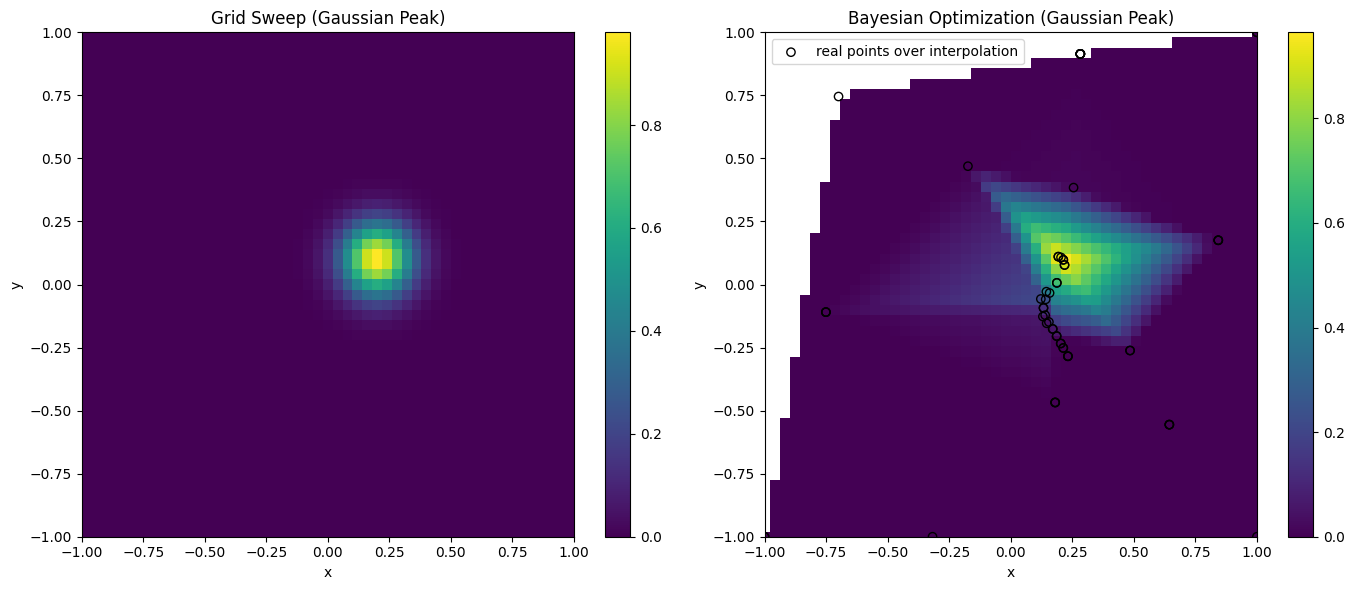

In [38]:
# Extract x, y, and z for plotting
x_vals = [p[f"{param_names[0]}"] for p in results['suggested_params']]
y_vals = [p[f"{param_names[1]}"] for p in results['suggested_params']]

# Create a grid sweep version (51 x 51 points)
x = np.linspace(-1, 1, 51)
y = np.linspace(-1, 1, 51)
x_grid, y_grid = np.meshgrid(x, y)
z_grid = np.exp(-((x_grid - 0.2) ** 2 + (y_grid - 0.1) ** 2) / (2 * 0.1**2))

# Create interpolation for the scatter plot using scipy's griddata
x_interp = np.linspace(-1, 1, 50)
y_interp = np.linspace(-1, 1, 50)
x_interp_grid, y_interp_grid = np.meshgrid(x_interp, y_interp)
z_interp = griddata(
    (x_vals, y_vals), observed_z, (x_interp_grid, y_interp_grid), method="linear"
)

# Plotting the grid sweep and Bayesian optimization results
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Pcolormesh for grid sweep version
c1 = ax[0].pcolormesh(x_grid, y_grid, z_grid, shading="auto", cmap="viridis")
ax[0].set_title("Grid Sweep (Gaussian Peak)")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
fig.colorbar(c1, ax=ax[0])

# Scatter plot with interpolation for Bayesian optimization samples
c2 = ax[1].pcolormesh(
    x_interp_grid, y_interp_grid, z_interp, shading="auto", cmap="viridis"
)
ax[1].scatter(
    x_vals,
    y_vals,
    edgecolor="black",
    facecolor="none",
    label="real points over interpolation",
)
ax[1].set_title("Bayesian Optimization (Gaussian Peak)")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].legend()
fig.colorbar(c2, ax=ax[1])

for ax in ax:
    ax.set_ylim(-1, 1)
    ax.set_xlim(-1, 1)

plt.tight_layout()
plt.show()

# SCRAP

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from ax import optimize
from ax.service.ax_client import AxClient
from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy
from ax.modelbridge.registry import Models
from ax.models.torch.botorch_modular.surrogate import Surrogate
from botorch.models.gp_regression import SingleTaskGP
from botorch.acquisition import qNegIntegratedPosteriorVariance
import random
from typing import Tuple
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from ax.utils.common.logger import get_logger

logger = get_logger(__name__)
from gpytorch.settings import max_cg_iterations


def bayesian_optimizer(num_initial_samples: int = 10, num_bo_samples: int = 100, epsilon: float = 1e-3, patience: int = 15, refit_every: int = 10, exploit_ratio: float = 0.9, seed: int = 1):
    """
    Bayesian optimization function that yields new points to sample.

    Args:
        num_initial_samples (int): Number of initial Sobol samples for exploration.
        num_bo_samples (int): Maximum number of Bayesian optimization samples to be taken after the initial exploration.
        epsilon (float): Convergence threshold.
        patience (int): Number of iterations without improvement to allow before stopping early.
        refit_every (int): Number of iterations after which the GP model is refit.
        exploit_ratio (float): Proportion of times exploitation (GPEI) is used compared to exploration (qNIPV).
        seed (int): Random seed for reproducibility.
    """
    # Set random seed for reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)

    # Setting up the Bayesian optimizer using Ax with a custom generation strategy.
    generation_strategy = GenerationStrategy(
        steps=[
            GenerationStep(model=Models.SOBOL, num_trials=num_initial_samples),
            GenerationStep(model=Models.GPEI, num_trials=-1),
        ]
    )

    ax_client = AxClient(generation_strategy=generation_strategy)
    ax_client.create_experiment(
        name="2d_gaussian_peak_optimization",
        parameters=[
            {"name": "x", "type": "range", "bounds": [-1.0, 1.0]},
            {"name": "y", "type": "range", "bounds": [-1.0, 1.0]},
        ],
        objective_name="z",
        minimize=False,  # Set True if you want to minimize the objective
    )

    # Lists to store sampled points and their objective values.
    z_samples = []
    x_samples = []
    y_samples = []

    # Initial exploration with Sobol sampling.
    for _ in range(num_initial_samples):
        params, trial_index = ax_client.get_next_trial()
        x_sample, y_sample = params['x'], params['y']
        z = np.exp(-((x_sample - 0.2) ** 2 + (y_sample - 0.1) ** 2) / (2 * 0.1 ** 2))
        x_samples.append(x_sample)
        y_samples.append(y_sample)
        z_samples.append(z)
        ax_client.complete_trial(trial_index=trial_index, raw_data=z)
        yield x_sample, y_sample, z

    # Define and fit the GP model.
    x_y_samples_tensor = torch.tensor(np.column_stack([x_samples, y_samples])).double()
    z_samples_tensor = torch.tensor(z_samples).double().unsqueeze(-1)
    gp_model = SingleTaskGP(x_y_samples_tensor, z_samples_tensor)
    mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
    fit_gpytorch_model(mll)

    # Bayesian optimization loop with convergence criteria.
    best_value = None
    no_improvement_counter = 0

    for i in range(num_bo_samples):
        # Randomly decide whether to use exploitation (GPEI) or exploration (qNIPV)
        rand_value = random.random()
        if rand_value < exploit_ratio:
            logger.info("Using GPEI for exploitation")
            ax_client.generation_strategy._steps[-1].model = Models.GPEI
        else:
            logger.info("Using qNIPV for exploration")
            ax_client.generation_strategy._steps[-1].model = Models.BOTORCH_MODULAR
            ax_client.generation_strategy._steps[-1].model_kwargs = {
                "surrogate": Surrogate(SingleTaskGP),
                "botorch_acqf_class": qNegIntegratedPosteriorVariance,
                "acquisition_options": {"mc_points": 10},
            }

        params, trial_index = ax_client.get_next_trial()
        x_sample, y_sample = params['x'], params['y']
        z = np.exp(-((x_sample - 0.2) ** 2 + (y_sample - 0.1) ** 2) / (2 * 0.1 ** 2))
        x_samples.append(x_sample)
        y_samples.append(y_sample)
        z_samples.append(z)
        ax_client.complete_trial(trial_index=trial_index, raw_data=z)
        yield x_sample, y_sample, z

        x_y_samples_tensor = torch.tensor(np.column_stack([x_samples, y_samples])).double()
        z_samples_tensor = torch.tensor(z_samples).double().unsqueeze(-1)

        if i % refit_every == 0 or i == num_bo_samples - 1:
            gp_model.set_train_data(x_y_samples_tensor, z_samples_tensor, strict=False)
            with max_cg_iterations(50):  # Use fewer iterations for solving GP equations
                fit_gpytorch_model(mll)
                
        if rand_value < exploit_ratio:
            if best_value is None or z > best_value + epsilon:
                best_value = z
                no_improvement_counter = 0
            else:
                no_improvement_counter += 1

        if no_improvement_counter >= patience:
            print(f"Stopping early after {i + 1} iterations due to lack of improvement.")
            break


In [ ]:
# Use the Bayesian optimizer to get new points.
x_samples, y_samples, z_samples = [], [], []
for x_sample, y_sample, z in bayesian_optimizer():
    x_samples.append(x_sample)
    y_samples.append(y_sample)
    z_samples.append(z)

In [ ]:
# Create a grid sweep version (51 x 51 points).
x = np.linspace(-1, 1, 51)
y = np.linspace(-1, 1, 51)
x_grid, y_grid = np.meshgrid(x, y)
z_grid = np.exp(-((x_grid - 0.2) ** 2 + (y_grid - 0.1) ** 2) / (2 * 0.1 ** 2))



# Create interpolation for the scatter plot using scipy's griddata.
x_interp = np.linspace(-1, 1, 50)
y_interp = np.linspace(-1, 1, 50)
x_interp_grid, y_interp_grid = np.meshgrid(x_interp, y_interp)
z_interp = griddata((x_samples, y_samples), z_samples, (x_interp_grid, y_interp_grid), method='linear')

# Plotting the grid sweep version.
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Pcolormesh for grid sweep version.
c1 = ax[0].pcolormesh(x_grid, y_grid, z_grid, shading='auto', cmap='viridis')
ax[0].set_title("Grid Sweep (Gaussian Peak)")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
fig.colorbar(c1, ax=ax[0])

# Scatter plot with interpolation for Bayesian optimization samples.
c2 = ax[1].pcolormesh(x_interp_grid, y_interp_grid, z_interp, shading='auto', cmap='viridis')
ax[1].scatter(x_samples, y_samples, edgecolor='black', facecolor='none')
ax[1].set_title("Bayesian Optimization (Gaussian Peak)")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
fig.colorbar(c2, ax=ax[1])

plt.tight_layout()
plt.show()